In [1]:
## built-in
import pdb
import time
import logging
from datetime import datetime

## 3rd
# torch
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler

from torch.utils.data import DataLoader

# Custom
from models.deeplabv3 import deeplabv3_mobilenet_v3
from datasets import CustomDataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [3]:
class TensorToNumpyImage:
    def __init__(self, mean: list=[0.485, 0.456, 0.406], std: list=[0.229, 0.224, 0.225], uint8: bool = False):
        self.mean = mean
        self.std = std
        self._uint8 = uint8

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            array (numpy.ndarray): Numpy array of size (H, W, C). ([0..1] for floats or [0..255] for integers)
        """
        _tensor = tensor.detach().cpu().clone()
        for t, m, s in zip(_tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        
        if self._uint8:
            return _tensor.mul_(255).numpy().astype(np.uint8).transpose(1, 2, 0)
        else:
            return _tensor.numpy().transpose(1, 2, 0)

tensor2image_float = TensorToNumpyImage(uint8=False)
tensor2image_uint8 = TensorToNumpyImage(uint8=True)

In [4]:
def count_parameters(model: nn.Module):
    """Count the number of parameters of a model.
    Args:
        model (torch.nn.Module):

    Returns:
        n_prm:
        n_trainable_prm:
        
    ref: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    """
    n_trainable_prm = sum(p.numel() for p in model.parameters() if p.requires_grad)
    n_prm = sum(p.numel() for p in model.parameters())
    return n_prm, n_trainable_prm

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))


config = dict(epochs=30, batch_size=1)

TRAIN_PROCESS = ['val']
TRAIN_JSON = {
    "val":
    # f"/opt/ml/Git/final-project-level3-cv-10/data/sample.valid.json",
    '/opt/ml/data/final-project/images/val.json',
}

def get_train_transform():
    return A.Compose([
        A.Resize(240, 427),
        A.RandomCrop(240, 320),
        # A.Resize(480, 854),
        # A.RandomCrop(480, 640),
        # A.HorizontalFlip(p=0.5),
        # A.Normalize(),
        ToTensorV2()
    ])

defined_transforms = {
    'val': get_train_transform(),
}

recycle_dataset = {
    x: CustomDataset(
        data_json=TRAIN_JSON[x],
        transforms=defined_transforms[x],
    )
    for x in TRAIN_PROCESS
}

dataloaders = {
    x: DataLoader(
        recycle_dataset[x],
        batch_size=config['batch_size'],
        num_workers=1,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn,
    )
    for x in TRAIN_PROCESS
}

_dataloader = iter(dataloaders['val'])

cats = recycle_dataset['val'].coco.cats
catName = {i: cats[i]['name'] for i in range(1, 22)}
catName[0] = 'background'

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Finished 'CustomDataset' in 0.0359 secs


In [5]:
# model_file_name = '../model_weights_aux2.ptbb_adamw.pth'
# model_file_name = '../model_weights_aux_reduced.ptbb_adamw.final.pth'
# model_file_name = '/opt/ml/Git/final-project-level3-cv-10/porting/model_weights_aux_ptbb_39_best.pth'

model = deeplabv3_mobilenet_v3(
    # pretrained=False,
    pretrained_backbone=False,
    aux_loss=False,
    small=True,
    grid_mode=True,
    reduced_tail=True,
    # reduced_tail=False,
).to(device)

# tmp = torch.load(model_file_name)
# for w_name in list(tmp.keys())[-8:]:
#     del tmp[w_name]
# model.load_state_dict(tmp)

model.to(device)
model.eval()  # Set model to evaluate mode

# torch.save(model.state_dict(), 'dlv3_mbv3-large_reduced_grid.211221.pth')
# torch.save(model, 'dlv3_mbv3-large_reduced_grid.211221.pt')

DeepLabV3(
  (backbone): Sequential(
    (0): Module(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): Module(
      (block): Module(
        (0): Module(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Module(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (scale_activation): Hardsigmoid()
        )
        (2): Module(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, 

In [10]:
dummy_image = torch.Tensor(np.random.random([1, 3, 240, 320])).to(device=device)

In [25]:
%%timeit

model.forward(dummy_image)

105 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
print(count_parameters(model))
print(count_parameters(model.backbone))
print(count_parameters(model.classifier))

(6129974, 6129974)
(927008, 927008)
(5202966, 5202966)


In [13]:
image = torch.Tensor(np.random.random(size=[1, 3, 240, 320])).to(device)
out = model.backbone(image)['out']
print(out.shape)
out = model.classifier(out)
print(out.shape)


torch.Size([1, 576, 15, 20])
torch.Size([1, 22, 15, 20])


(0.0, 1.0, 0.0, 1.0)

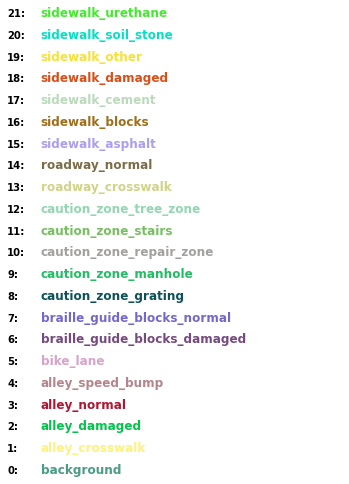

In [14]:
np.random.seed(12)
colors = np.random.randint(0, 256, [22, 3])
for i in range(22):
    plt.text(0, i*0.1, f"{i}:", fontweight='bold')
    plt.text(0.1, i*0.1, catName[i], color=colors[i]/255, fontweight='bold', fontsize='large')
plt.axis('off')

@ Surface_232/MP_SEL_SUR_016227.jpg
true [ 0 12 14 16]
true ['background', 'caution_zone_tree_zone', 'roadway_normal', 'sidewalk_blocks']
predicted [ 0 12 14 16]
predicted ['background', 'caution_zone_tree_zone', 'roadway_normal', 'sidewalk_blocks']


(-0.5, 319.5, 239.5, -0.5)

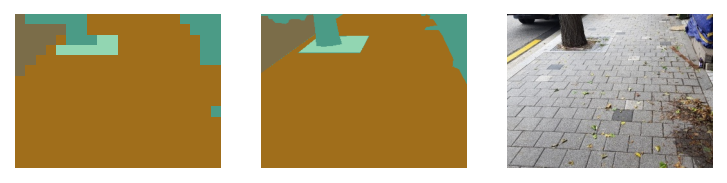

In [53]:
images, masks, image_infos = next(_dataloader)

images = torch.stack(images).to(device)
masks = torch.stack(masks).long().to(device)

# outputs = model.forward(images)['out']
outputs = model.forward(images)

masks = masks.cpu().numpy()
# outputs = outputs.detach().cpu().numpy()
outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
_masks = np.unique(masks)
print('@', image_infos[0]['file_name'])
print("true", _masks)
print("true", [catName[i] for i in _masks])
_outputs = np.unique(outputs)
print("predicted", _outputs)
print("predicted", [catName[i] for i in _outputs])

fig, axes = plt.subplots(1, 3, dpi=150)
# axes[0].imshow(outputs[0])
axes[0].imshow(colors[outputs[0]])
# axes[0].legend([catName[i] for i in _outputs])
axes[0].axis('off')
# axes[1].imshow(masks[0])
axes[1].imshow(colors[masks[0]])
axes[1].axis('off')
# axes[2].imshow(tensor2image_float(images[0]))
axes[2].imshow(images[0].cpu().numpy().transpose([1, 2, 0]))
axes[2].axis('off')